In [4]:
import os.path as op
import os
# import sys
import numpy as np
import pandas as pd
import seaborn as sns
from fpdf import FPDF  

import mne
from mne.preprocessing import find_bad_channels_maxwell
import matplotlib.pyplot as plt
from mne.time_frequency import psd_multitaper
from mne.preprocessing import annotate_muscle_zscore
from mne.preprocessing import ICA
from mne.preprocessing import read_ica
import scipy.stats

## Preprocessing

In [5]:
experiment_id = 1
# subject_id = '035'

# Set user-specific params
user = os.getlogin()  #TODO: @Ling the command "os.environ['USER']" doesn0t work on Win. Can you try this other one?


file_path = r'/Volumes/Cogitate/MEG_reorganized/'
cal_path = r'/Users/bryan/Downloads/Peking_U/Data/cogitate/cal_file/'
site_id = 'SB'

subject_list = [i[2:] for i in os.listdir(file_path) if site_id in i] 

In [6]:
subject_list

['127', '128', '130', '131', '129']

In [7]:
# %load config.py
"""
===========
Config file
===========

Configurate the parameters of the study.
"""
for subject_id in subject_list[:1]:

    # =============================================================================
    # SESSION-SPECIFIC SETTINGS
    # =============================================================================

    # Set filename based on experiment number
    if experiment_id == 1:
        file_exts = ['%s_MEEG_V1_DurR1',
                     '%s_MEEG_V1_DurR2',
                     '%s_MEEG_V1_DurR3',
                     '%s_MEEG_V1_DurR4',
                     '%s_MEEG_V1_DurR5']
        file_names = [f % (site_id+subject_id) for f in file_exts]
    elif experiment_id == 2:
        file_exts = ['%s_MEEG_V2_VGR1',
                     '%s_MEEG_V2_VGR2',
                     '%s_MEEG_V2_VGR3',
                     '%s_MEEG_V2_VGR4']#,
                     # '%s_MEEG_V2_ReplayR1',
                     # '%s_MEEG_V2_ReplayR2']
        file_names = [f % (site_id+subject_id) for f in file_exts]


    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    data_path = op.join(file_path,site_id+subject_id)
    data_path = op.join(data_path,'V' + str(experiment_id))
    out_path = op.join(data_path, "out_path")
    if not op.exists(out_path):
        os.mkdir(out_path)

    # Remove participant without EEG from EEG analysis (WIP, only works for exp1 atm)
    if site_id == 'SA':
        if experiment_id == 1:
            no_eeg_sbj = ['101', '102', '103', '104']
        elif experiment_id == 2:
            no_eeg_sbj = ['104', '106']
    elif site_id == 'SB':
        if experiment_id == 1:
            no_eeg_sbj = []
        elif experiment_id == 2:
            no_eeg_sbj = []


    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='sss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None


    # =============================================================================
    # FILTERING AND DOWNSAMPLING SETTINGS
    # =============================================================================

    # Filter and resampling params
    l_freq = 1
    h_freq = 40
    sfreq = 200


    # =============================================================================
    # ICA SETTINGS
    # =============================================================================

    ica_method = 'fastica'
    n_components = 0.99
    max_iter = 800
    random_state = 1688




In [ ]:
import time
 
start = time.clock()
crosstalk_file = op.join(cal_path, "ct_sparse_" + site_id + ".fif")
fine_cal_file = op.join(cal_path, "sss_cal_" + site_id + ".dat")

# Create empty dataframe for bad channel list
df = pd.DataFrame()

# Prepare PDF report
pdf = FPDF(orientation="P", unit="mm", format="A4")

print("Processing subject: %s" % subject_id)
run = 0
for file_name in file_names[:1]:
    run = run + 1
    print("  File: %s" % file_name)

    # Read raw data
    raw_fname_in = op.join(data_path, file_name + '.fif')
    raw = mne.io.read_raw_fif(
        raw_fname_in,
        allow_maxshield=True,
        preload=False,
        verbose=True)

    # Detect bad channels
    raw.info['bads'] = []
    raw_check = raw.copy()
    auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
        raw_check, 
        cross_talk=crosstalk_file, 
        calibration=fine_cal_file,
        return_scores=True,
        verbose=True)
    raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
elapsed = (time.clock() - start)
print("Time used:",elapsed)

In [14]:
# %load 01-maxwell_filtering.py
"""
===================================
01. Maxwell filter using MNE-python
===================================

The data are Maxwell filtered using tSSS/SSS.

It is critical to mark bad channels before Maxwell filtering.

Open issues:
    1. SSS or tSSS? -> Consult Alex G.?
    
"""  # noqa: E501


def run_maxwell_filter(method = 'sss'):
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    # os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Load the fine calibration file (which encodes site-specific information 
    # about sensor orientation and calibration) as well as a crosstalk 
    # compensation file (which reduces interference between Elekta’s co-located
    # magnetometer and paired gradiometer sensor units)
    crosstalk_file = op.join(cal_path, "ct_sparse_" + site_id + ".fif")
    fine_cal_file = op.join(cal_path, "sss_cal_" + site_id + ".dat")
    
    # Create empty dataframe for bad channel list
    df = pd.DataFrame()
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(data_path, file_name + '.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in,
            allow_maxshield=True,
            preload=False,
            verbose=True)
        
        # Detect bad channels
        raw.info['bads'] = []
        raw_check = raw.copy()
        auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
            raw_check, 
            cross_talk=crosstalk_file, 
            calibration=fine_cal_file,
            return_scores=True,
            verbose=True)
        raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
        
        # Append bad channels to the list 
        df = df.append({'run': run,
                        'noisy': auto_noisy_chs, 
                        'flat': auto_flat_chs},
                        ignore_index=True)        
        
        # Visualize the scoring used to classify channels as noisy or flat
        ch_type = 'grad'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_r%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        ch_type = 'mag'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_r%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        
        # Fix Elekta magnetometer coil types
        raw.fix_mag_coil_types()
        
        # Perform tSSS/SSS and Maxwell filtering
        raw_sss = mne.preprocessing.maxwell_filter(
            raw,
            cross_talk=crosstalk_file,
            calibration=fine_cal_file,
            st_duration=st_duration,
            #coord_frame="meg", #only for empy room, comment it if using HPI
            verbose=True)
        
        # Show original and filtered signals
        fig = raw.copy().pick(['meg']).plot(duration=5,
                                            start=100,
                                            butterfly=True)        
        fname_fig = op.join(out_path,
                            '01_r%s_plotraw.png' % run)
        fig.savefig(fname_fig)
        plt.close()
        fig = raw_sss.copy().pick(['meg']).plot(duration=5,
                                                start=100,
                                                butterfly=True)
        fname_fig = op.join(out_path,
                            '01_r%s_plotraw%s.png' % (run,method))
        fig.savefig(fname_fig)
        plt.close()
        
        # Show original and filtered power
        fig1 = raw.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig1 = op.join(out_path,
                            '01_r%s_plot_psd_raw100.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        fig2 = raw_sss.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig2 = op.join(out_path,
                            '01_r%s_plot_psd_raw100%s.png' % (run,method))
        fig2.savefig(fname_fig2)
        plt.close()
        
        # Add figures to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Power Spectrum of Raw MEG Data', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        pdf.ln(120)
        pdf.cell(0, 10, 'Power Spectrum of Filtered MEG Data', 'B', ln=1)
        pdf.image(fname_fig2, 0, 175, pdf.epw)
        
        # Save filtered data
        fname_out = op.join(out_path,
                            file_name + '_' + method + '.fif')
        raw_sss.save(fname_out, overwrite=True)
        
    # Save bad channel list
    df.to_csv(op.join(out_path,
                      '01_rAll_meg_badch_list.csv'),
              index=False)
    
    # Save report
    pdf.output(op.join(out_path,
                      'run_maxwell_filter' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt


def viz_badch_scores(auto_scores, ch_type):
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    fig.suptitle(f'Automated noisy/flat channel detection: {ch_type}',
                  fontsize=16, fontweight='bold')
    
    #### Noisy channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_noisy'][ch_subset]
    limits = auto_scores['limits_noisy'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[0].set_title('Noisy: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmin=np.nanmin(limits),
                cmap='Reds', 
                cbar=True, 
                # cbar_kws=dict(label='Score'), 
                ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[1].set_title('Noisy: Scores > Limit', fontweight='bold')
    
    #### Flat channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_flat'][ch_subset]
    limits = auto_scores['limits_flat'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[2])
    [ax[2].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[2].set_title('Flat: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmax=np.nanmax(limits),
                cmap='Reds', 
                cbar=True,
                # cbar_kws=dict(label='Score'), 
                ax=ax[3])
    [ax[3].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[3].set_title('Flat: Scores > Limit', fontweight='bold')
    
    # Fit figure title to not overlap with the subplots
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig





In [15]:
# %load 02-find_bad_eeg.py
"""
===================================
02. Find bad EEG sensors
===================================

EEG bad sensors are found using a simplified version of the PREP pipeline procedure.

"""  # noqa: E501

def find_bad_eeg():
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                           os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Create empty dataframe for bad channel list
    df = pd.DataFrame()
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_' + method + '.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Check if there are EEG data
        try:
            raw.copy().pick('eeg')
        except Exception as e:
            print(e)
            raise ValueError("Error: there is no EEG recording for this participant (%s)" % (site_id+subject_id))
        
        ##############################################
        # PHASE 1 : Estimate the true signal average #
        ##############################################
        
        # Select EEG data
        raw_eeg = raw.copy().pick('eeg')
        
        # Reset bads
        raw_eeg.info['bads'] = []
        
        # Plot EEG data
        fig = raw.copy().pick('eeg').plot(bad_color=(1., 0., 0.),
                                          scalings = dict(eeg=10e-5),
                                          duration=5,
                                          start=100)
        fname_fig = op.join(out_path,
                            '02_r%s_bad_egg_0raw.png' % run)
        fig.savefig(fname_fig)
        plt.close()
        
        # Plot EEG power spectrum
        fig1 = viz_psd(raw_eeg)
        fname_fig1 = op.join(out_path,
                            '02_r%s_bad_egg_0pow.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Power Spectrum of Raw EEG Data', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        
        # Init temporary copy of EEG
        raw_eeg_temp = raw_eeg.copy()
        
        # Init average reference
        ref_temp = np.median(raw_eeg_temp._data.copy(), axis=-2, keepdims=True)
        
        # Apply initial average reference
        raw_eeg_temp._data -= ref_temp
        
        # Init bad channel list
        bad_channels = []
        
        # Set max number of iterations and init iteration
        iteration_max = 100
        
        # Detect bad channels and recalculate the reference based on their interpolation
        for i in range(iteration_max):
            # Actual bad channel detection
            bads_temp = []
            bads_temp = find_bad_channels_eeg(raw_eeg_temp)
            
            # Exit loop if no new bad channels are found
            if all(bad in bad_channels for bad in bads_temp):
                break
            else:
                # Add new bad channel to the list
                bad_channels += bads_temp
                
                # Set bad channels
                raw_eeg_temp.info['bads'].extend(bads_temp)
                
                # Interpolate bad channels from the original data
                raw_eeg_temp = raw_eeg_temp.interpolate_bads(reset_bads=True)
                
                # Get the new average reference
                ref_temp = raw_eeg_temp._data.copy().mean(-2, keepdims=True)
                
                # Get new temp data by removing the new reference from the orignal data
                raw_eeg_temp._data = raw_eeg._data.copy() - ref_temp
        
        # Mark loop bad channels in a new copy of the data
        raw_eeg_bad = raw_eeg.copy()
        raw_eeg_bad.info['bads'].extend(bad_channels)
        
        # Interpolate loop bad channels
        raw_eeg_bad = raw_eeg_bad.interpolate_bads(reset_bads=False)
        
        # Get the true average reference
        ref_true = raw_eeg_bad._data.copy().mean(-2, keepdims=True)
        
        ############################################################################
        # PHASE 2 : Find the bad channels relative to true average and interpolate #
        ############################################################################
        
        # Remove true average reference from original EEG data
        eeg_idx = mne.pick_types(raw.info, meg=False, eeg=True, exclude=[])
        raw._data[..., eeg_idx, :] -= ref_true
        
        # Plot true referenced EEG data
        fig = raw.copy().pick('eeg').plot(bad_color=(1., 0., 0.),
                                          scalings = dict(eeg=10e-5),
                                          duration=5,
                                          start=100)
        fname_fig = op.join(out_path,
                            '02_r%s_bad_egg_1true.png' % run)
        fig.savefig(fname_fig)
        plt.close()
        
        # Find true bad channels
        bads_true = find_bad_channels_eeg(raw.copy().pick('eeg'))
        
        # Append true bad channels to the list 
        df = df.append({'run': run,
                        'bad': bads_true}, 
                        ignore_index=True)
        
        # Mark true bad channels
        raw.info['bads'].extend(bads_true)
        
        # Interpolate true bad channels
        raw = raw.interpolate_bads(reset_bads=False)
        
        # Plot interpolated EEG data
        fig = raw.copy().pick('eeg').plot(bad_color=(1., 0., 0.),
                                          scalings = dict(eeg=10e-5),
                                          duration=5,
                                          start=100)
        fname_fig = op.join(out_path,
                            '02_r%s_bad_egg_2intrp.png' % run)
        fig.savefig(fname_fig)
        plt.close()
        
        # Remove the new average reference to correct for the previous referencing
        raw.set_eeg_reference(ref_channels='average', projection=False)  #if projection=True, the reference is added as a projection and is not applied to the data (it can be applied afterwards with the apply_proj method)
        
        # Get reference correction
        ref_corr = raw.copy().pick('eeg')._data.mean(-2, keepdims=True)
        
        # Add correction to reference signal stored in raw
        ref_true += ref_corr  #TODO: where in raw is the ref stored?
        
        # Plot referenced EEG data
        fig = raw.copy().pick('eeg').plot(bad_color=(1., 0., 0.),
                                          scalings = dict(eeg=10e-5),
                                          duration=5,
                                          start=100)
        fname_fig = op.join(out_path,
                            '02_r%s_bad_egg_3refer.png' % run)
        fig.savefig(fname_fig)
        plt.close()
        
        # Plot referenced EEG power spectrum
        fig2 = viz_psd(raw)
        fname_fig2 = op.join(out_path,
                            '02_r%s_bad_egg_Ipow.png' % run)
        fig2.savefig(fname_fig2)
        plt.close()
        
        # Add figures to report
        pdf.ln(120)
        pdf.cell(0, 10, 'Power Spectrum of Filtered EEG Data', 'B', ln=1)
        pdf.image(fname_fig2, 0, 175, pdf.epw)
        
        # Reset bads
        raw.info['bads'] = []
        
        # Save data
        fname_out = op.join(out_path,
                            file_name + '_intpl.fif')
        raw.save(fname_out, overwrite=True)
        
    # Save bad channel list
    df.to_csv(op.join(out_path,
                      '02_rAll_eeg_badch_list.csv'),
              index=False)
    
    # Save report
    pdf.output(op.join(out_path,
                       'find_bad_eeg' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt


def find_bad_channels_eeg(raw):
    ''' 
    Find bad EEG channels using on four criteria:
        - deviation criterion
        - correlation critetion
        - noisiness criterion
    '''
    
    #######################
    # DEVIATION CRITERION #
    #######################
        
    # Get eeg signal
    amps = raw.copy().pick('eeg')._data
    
    # Remove offset
    amps = amps - amps.mean(axis=1)[:,None]
    
    # Normalize (z-score) channel-specific amplitude
    amps_z= scipy.stats.zscore(amps, axis=None)
        
    # Average channel-specific amplitude
    amp_z_a = amps_z.mean(axis=1)
    
    # Find channels with amplitude above threshold
    thr = 5
    bad_by_deviation = np.where(amp_z_a > thr)[0]
    
    #########################
    # CORRELATION CRITERION #
    #########################
    
    # Low-pass eeg data to 50 Hz
    lowpass_signal = raw.copy().pick('eeg').filter(None, 50)
    
    # Compute channel-to-channel correlation
    data_for_corr = pd.DataFrame(np.transpose(lowpass_signal._data))
    all_corr = data_for_corr.corr()
    
    # Get max correlation of each channel  #TODO: store nr of datapoints and corr matrix
    all_corr[all_corr == 1] = 0
    max_cor = all_corr.max(axis=1)
    
    # Find channels with max correlation below threshold
    thr = .4
    bad_by_correlation = np.where(max_cor < thr)[0]
    
    #######################
    # NOISINESS CRITERION #
    #######################
    
    # Divide low and high frequency signals at 50 Hz
    lowpass_signal = raw.copy().pick('eeg').filter(None, 50)
    
    highpass_signal = raw.copy().pick('eeg').filter(50, 100)
    
    # Compute power
    low_power, _ = psd_multitaper(lowpass_signal)
    low_power = np.sum(low_power, axis=1)
    
    high_power, _ = psd_multitaper(highpass_signal)
    high_power = np.sum(high_power, axis=1)
    
    # Get the high/low ratio
    pow_ratio = high_power/low_power
    
    # Normalize ratio
    pow_ratio_z = scipy.stats.zscore(pow_ratio, axis=None)
    pow_ratio_z = abs(pow_ratio_z)
    
    # Find channels with ratio above threshold
    thr = 5
    bad_by_HF_noise = np.where(pow_ratio_z > thr)[0]
    
    ####################
    # BAD CHANNEL LIST #
    ####################

    # Concatenate bad channel list and exclude repetitions
    b = np.unique(np.concatenate((bad_by_deviation, bad_by_correlation, bad_by_HF_noise)))
    bads = []
    for i in range(len(b)):
        bads.append("EEG0%02d"%(b[i]+1))
    return bads


def viz_psd(raw):
    # Compute averaged power
    psds, freqs = psd_multitaper(raw,fmin = 1,fmax = 40, picks=['eeg'])
    psds = np.sum(psds,axis = 1)
    psds = 10. * np.log10(psds)
    # Show power spectral density plot
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    raw.plot_psd(picks = ["eeg"], 
                  fmin = 1,fmax = 40,
                  ax=ax[0])
    # Normalize (z-score) channel-specific average power values 
    psd = {}
    psd_zscore = scipy.stats.zscore(psds)
    for i in range(len(psd_zscore)):
        psd["EEG%03d"%(i+1)] = psd_zscore[i]
    # Plot chennels ordered by power
    ax[1].bar(sorted(psd, key=psd.get,reverse = True),sorted(psd.values(),reverse = True),width = 0.5)
    labels = sorted(psd, key=psd.get,reverse = True)
    ax[1].set_xticklabels(labels, rotation=90)
    ax[1].annotate("Average power: %.2e dB"%(np.average(psds)),(27,np.max(psd_zscore)*0.9),fontsize = 'x-large')
    return fig



    

Processing subject: 127
  File: SB127_MEEG_V1_DurR3
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 368 significant peaks
Number of EOG events detected : 368


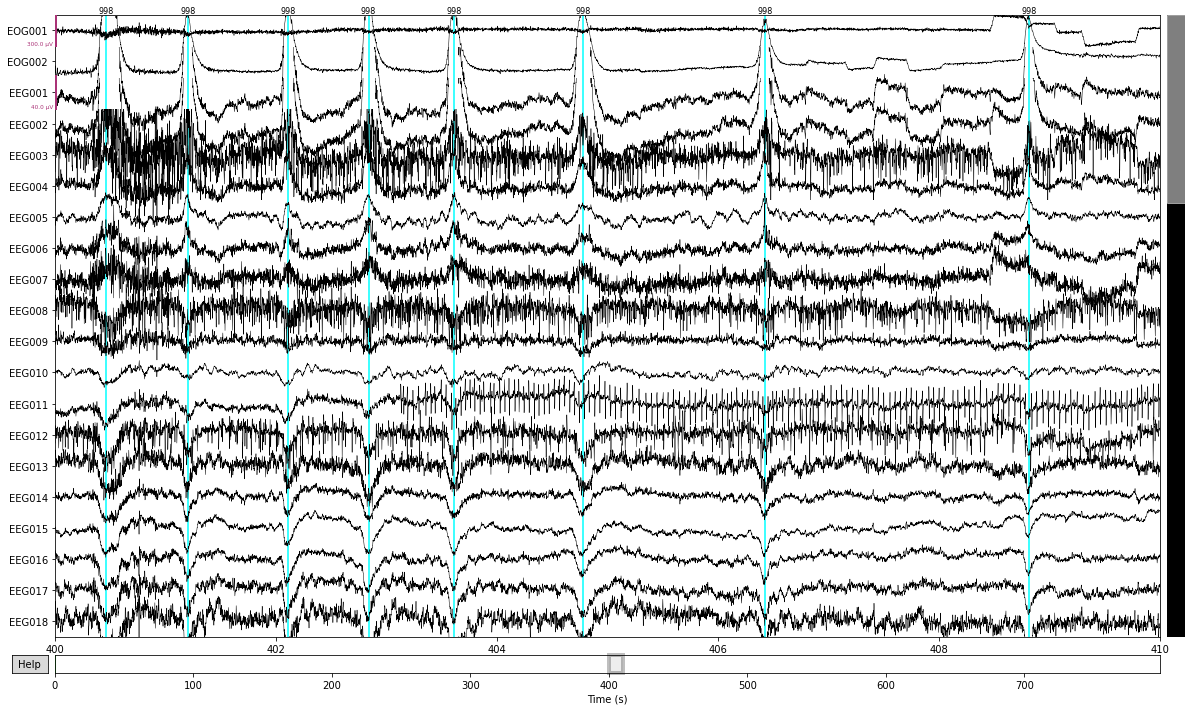

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)



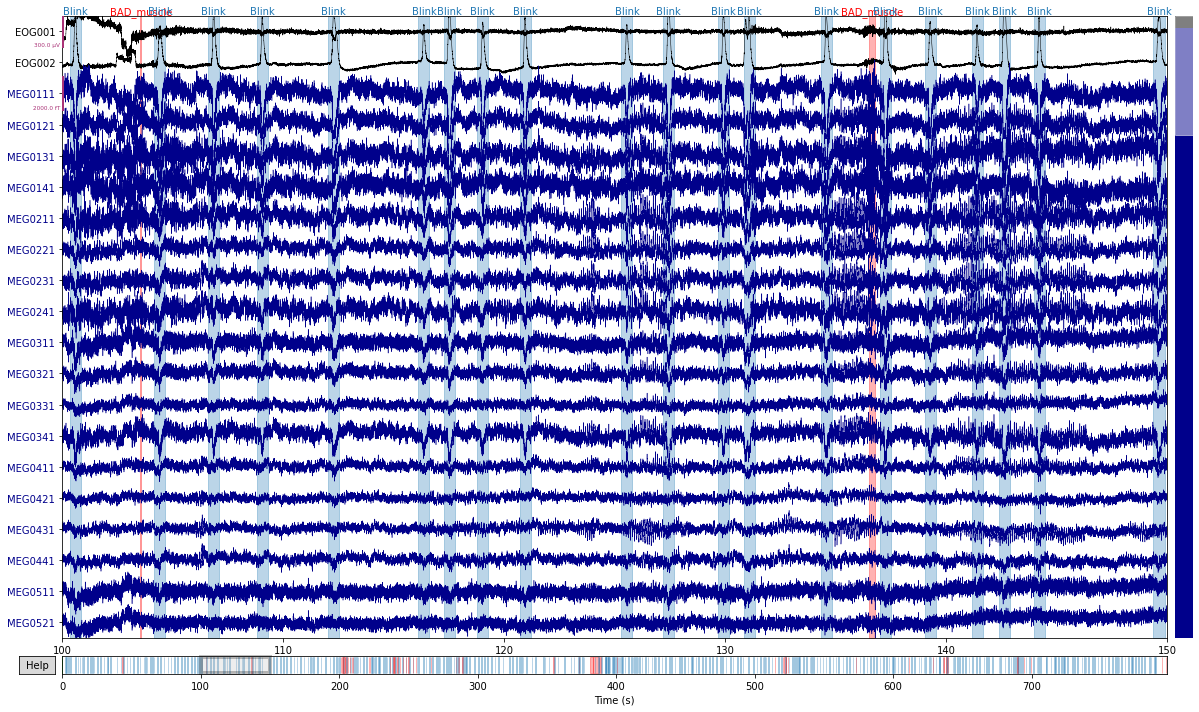

  File: SB127_MEEG_V1_DurR4
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 406 significant peaks
Number of EOG events detected : 406


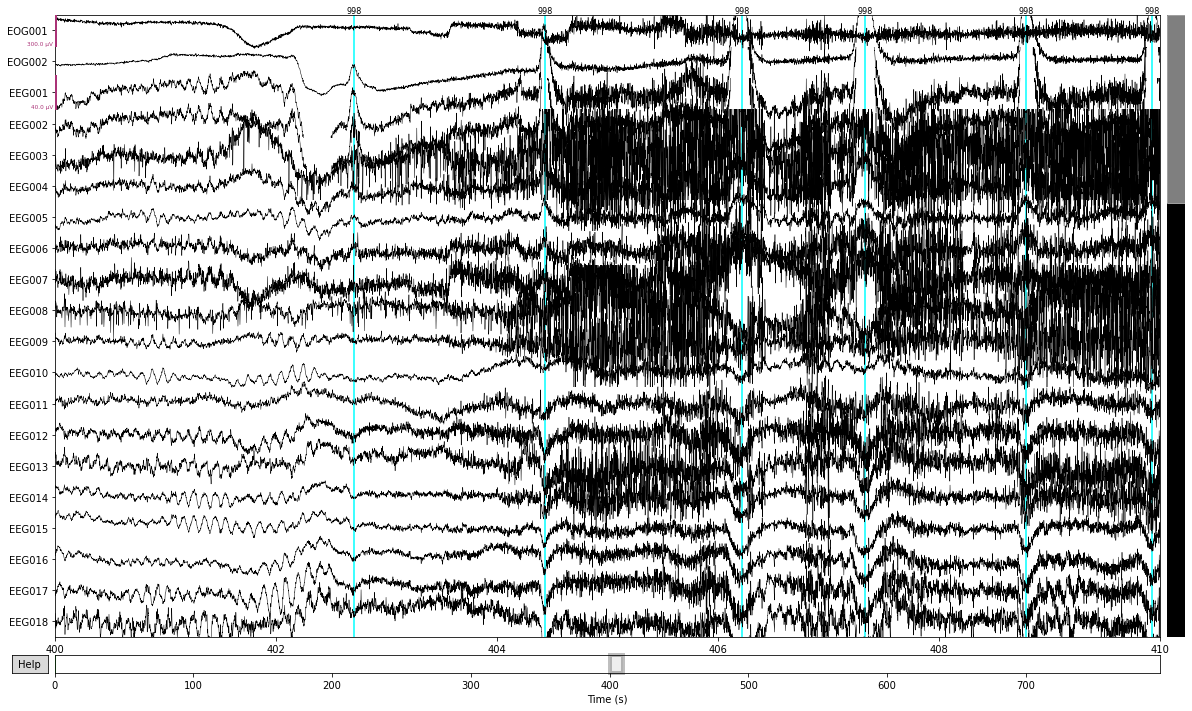

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)



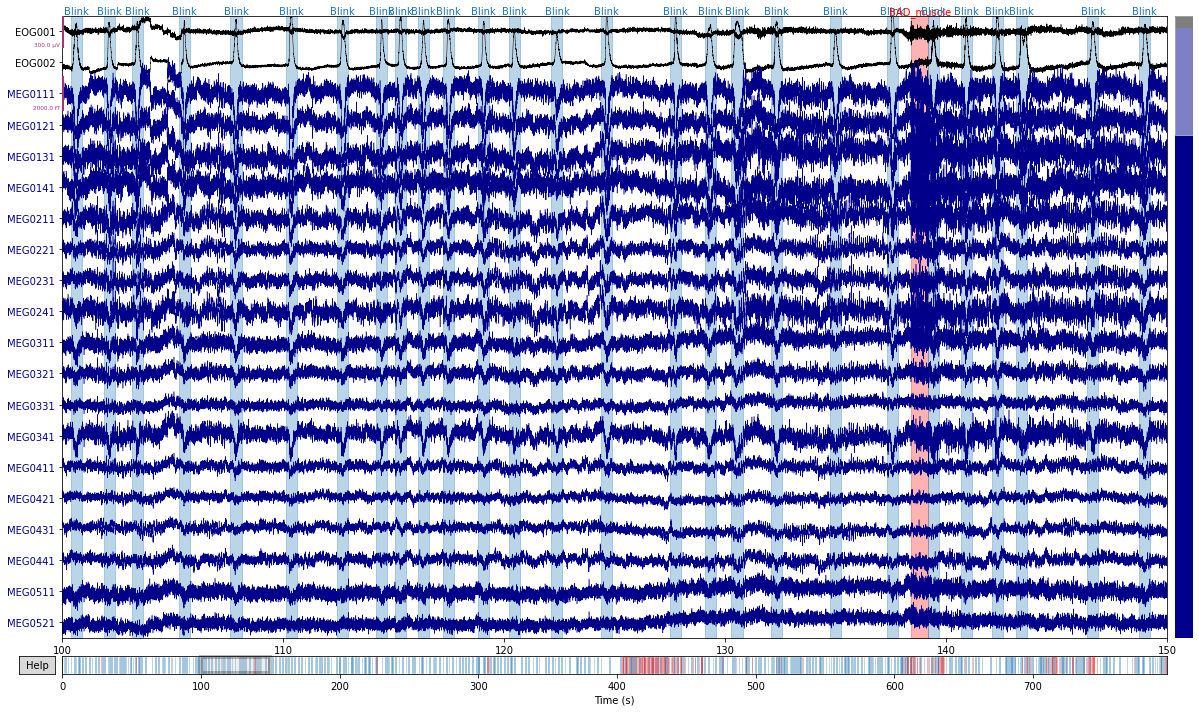

  File: SB127_MEEG_V1_DurR5
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 8 significant peaks
Number of EOG events detected : 8


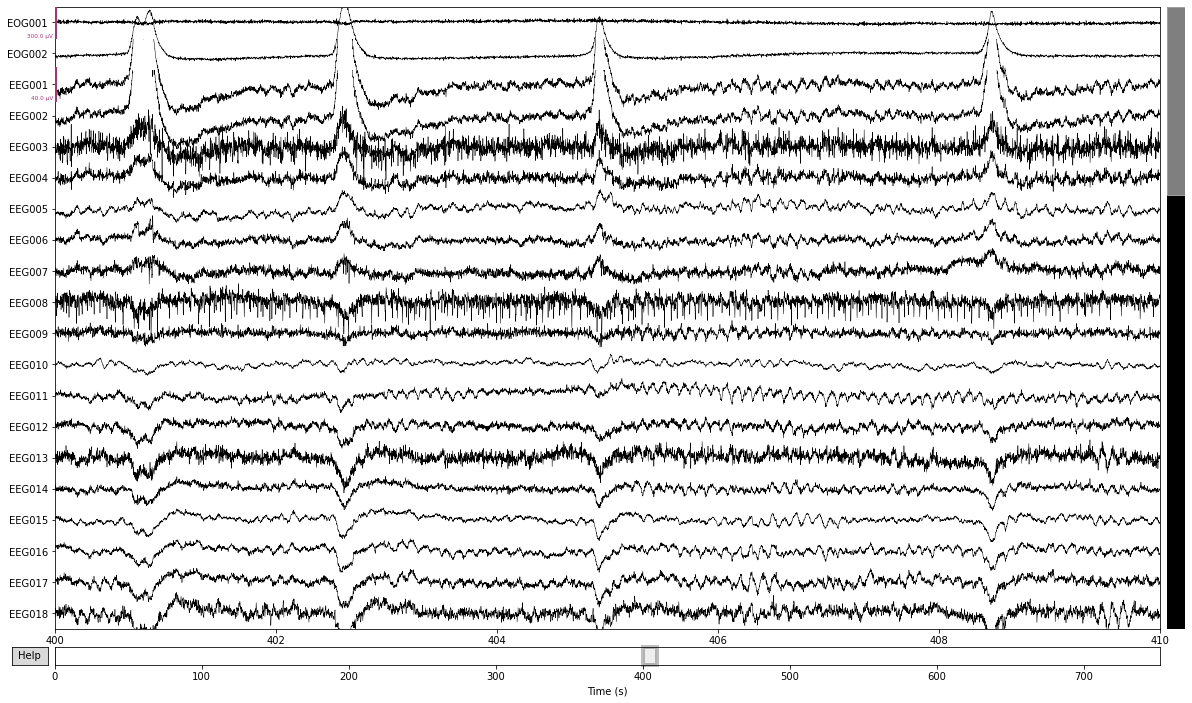

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)



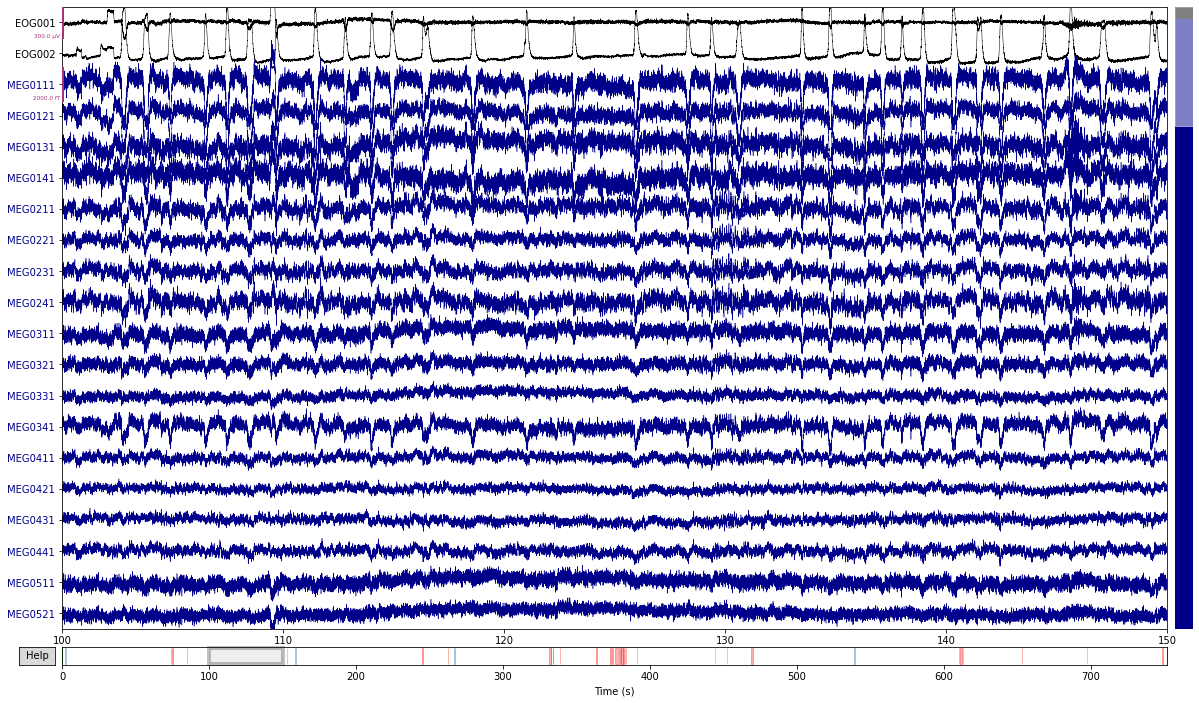

In [33]:
# file_names = file_names[2:]
# artifact_annotation()

In [32]:
# %load 03-artifact_annotation.py
"""
===========================
03. Artifact annotation
===========================

Detect and note ocular and muscle artifacts

Open issues:
    1. Eye-link annot?
    -> Ling will develop it

"""  # noqa: E501


def artifact_annotation():  
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
                              # os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_intpl.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Create empty annotations list
        annot_artifact = mne.Annotations(onset=[], 
                                         duration=[],
                                         description=[])
        
        ###########################
        # Detect ocular artifacts #
        ###########################
        
        # Resetting the EOG channel
        eog_ch = raw.copy().pick_types(meg=False, eeg=False, eog=True)
        if len(eog_ch.ch_names) < 2:
            raw.set_channel_types({'BIO002':'eog'})
            raw.rename_channels({'BIO002': 'EOG002'})
        
        if EEG:
            # Resetting the EOG channel  #TODO: test on Birmingham's data
            eog_ch = raw.copy().pick_types(meg=False, eeg=False, eog=True)
            if len(eog_ch.ch_names) < 2:
                raw.set_channel_types({'BIO002':'eog'})
                raw.rename_channels({'BIO002': 'EOG002'})
            
            # Find EOG events
            eog_events = mne.preprocessing.find_eog_events(raw)
            onsets = (eog_events[:, 0] - raw.first_samp) / raw.info['sfreq'] - 0.25
            durations = [0.5] * len(eog_events)
            descriptions = ['Blink'] * len(eog_events)
            
            # Annotate events
            annot_blink = mne.Annotations(
                onsets, 
                durations,
                descriptions)
                # orig_time=raw.info['meas_date'])
            
            # Add blinks to annotations list
            annot_artifact = annot_artifact + annot_blink
            
            # Plot blink with EEG data
            eeg_picks = mne.pick_types(raw.info, 
                                      meg=False,
                                      eeg=True,
                                      eog=True)
#             print(eog_events)
            fig = raw.plot(events=eog_events,
                          start=400,  ### correction: 800 -> 400 no element if too high
                          order=eeg_picks)
            fname_fig = op.join(out_path,
                               "03_r%s_artifact_blink.png" % run)
            fig.savefig(fname_fig)
            plt.close()
        
        ###########################
        # Detect muscle artifacts #
        ###########################
        
        # Notch filter
        raw_muscle = raw.copy().notch_filter([50, 100])
        
        # The threshold is data dependent, check the optimal threshold by plotting
        # ``scores_muscle``.
        threshold_muscle = 5  # z-score
        
        # Choose one channel type, if there are axial gradiometers and magnetometers,
        # select magnetometers as they are more sensitive to muscle activity.
        annot_muscle, scores_muscle = annotate_muscle_zscore(
            raw_muscle, 
            ch_type="mag", 
            threshold=threshold_muscle, 
            min_length_good=0.2,
            filter_freq=[110, 140])
        
        # Add muscle artifacts to annotations list
        annot_artifact = annot_artifact + annot_muscle
        
        # Plot muscle z-scores across recording
        fig1, ax = plt.subplots()
        ax.plot(raw.times, scores_muscle)
        ax.axhline(y=threshold_muscle, color='r')
        ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity')
        fname_fig1 = op.join(out_path,
                            "03_r%s_artifact_muscle.png" % run)
        fig1.savefig(fname_fig1)
        plt.close()
        
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Muscle artifact power', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        
        ###########################
        
        # Set annotations
        raw.set_annotations(annot_artifact)
        
        # View raw with annotations
        channel_picks = mne.pick_types(raw.info, 
                                       meg='mag', eog=True)
        fig2 = raw.plot(duration=50,
                       start=100,
                       order=channel_picks)
        fname_fig2 = op.join(out_path,
                            "03_r%s_artifact_annot.png" % run)
        fig2.savefig(fname_fig2)
        plt.close()
        
        # Add figures to report
        pdf.ln(120)
        pdf.cell(0, 10, 'Data and annotations', 'B', ln=1)
        pdf.image(fname_fig2, 0, 175, pdf.epw)
        
        # Save data with annotated artifacts
        fname_out = op.join(out_path,
                            file_name + '_artif.fif')                            
        raw.save(fname_out, overwrite=True)
    
    # Save report
    pdf.output(op.join(out_path,
                       'artifact_annotation' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [17]:
# %load 04-extract_events.py
"""
===================
04. Extract events
===================

Extract events from the stimulus channel

Open issues:
    - metadata for exp 2 needs to be created

"""


def run_events(experiment_id = 1):
    
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
                              # os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")

    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        run_fname = op.join(data_path,
                            file_name + '.fif')
        raw = mne.io.read_raw_fif(
            run_fname,
            allow_maxshield=True,
            verbose=True)
        
        ###############
        # Read events #
        ###############
    
        # Find response events
        response = mne.find_events(raw,
                                 stim_channel='STI101',
                                 consecutive = False,
                                 mask = 65280,
                                 mask_type = 'not_and'
                                )
        response = response[response[:,2] == 255]
        
        # Find all other events
        events = mne.find_events(raw,
                                 stim_channel='STI101',
                                 consecutive = True,
                                 min_duration=0.001001,
                                 mask = 65280,
                                 mask_type = 'not_and'
                                )
        events = events[events[:,2] != 255]
        
        # Concatenate all events
        events = np.concatenate([response,events],axis = 0)
        events = events[events[:,0].argsort(),:]
        
        # Show events
        fig = mne.viz.plot_events(events)
        fname_fig = op.join(out_path,
                            "04_r%s_events.png" % run)
        fig.savefig(fname_fig)
        plt.close(fig)
        
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Events', 'B', ln=1)
        pdf.image(fname_fig, 0, 45, pdf.epw)
        
        # Save event array
        fname_events = op.join(out_path,
                               file_name + '-eve.fif')                            
        mne.write_events(fname_events, events)
        
        #################
        # Read metadata #
        #################
        
        # Generate metadata table
        if experiment_id == 1:
            eve = events.copy()
            events = eve[eve[:, 2] < 81].copy()
            metadata = {}
            metadata = pd.DataFrame(metadata, index=np.arange(len(events)),
                                    columns=['Stim_trigger', 'Category',
                                             'Orientation', 'Duration',
                                             'Task_relevance', 'Trial_ID',
                                             'Response', 'Response_time(s)'])
            Category = ['face', 'object', 'letter', 'false']
            Orientation = ['Center', 'Left', 'Right']
            Duration = ['500ms', '1000ms', '1500ms']
            Relevance = ['Relevant target', 'Relevant non-target', 'Irrelevant']
            k = 0
            for i in range(eve.shape[0]):
                if eve[i, 2] < 81:
                ##find the end of each trial (trigger 97)
                    t = [t for t, j in enumerate(eve[i:i + 9, 2]) if j == 97][0]
                    metadata.loc[k]['Stim_trigger'] = eve[i,2]
                    metadata.loc[k]['Category'] = Category[int((eve[i,2]-1)//20)]
                    metadata.loc[k]['Orientation'] = Orientation[[j-100 for j in eve[i:i+t,2]
                                                                  if j in [101,102,103]][0]-1]
                    metadata.loc[k]['Duration'] = Duration[[j-150 for j in eve[i:i+t,2]
                                                            if j in [151,152,153]][0]-1]
                    metadata.loc[k]['Task_relevance'] = Relevance[[j-200 for j in eve[i:i+t,2]
                                                                   if j in [201,202,203]][0]-1]
                    metadata.loc[k]['Trial_ID'] = [j for j in eve[i:i+t,2]
                                                   if (j>110) and (j<149)][0]
                    metadata.loc[k]['Response'] = True if any(eve[i:i+t,2] == 255) else False
                    if metadata.loc[k]['Response'] == True:
                        r = [r for r,j in enumerate(eve[i:i+t,2]) if j == 255][0]
                        metadata.loc[k]['Response_time(s)'] = (eve[i+r,0] - eve[i,0])
                    # miniblock = [j for j in eve[i:i+t,2] if (j>160) and (j<201)]
                    # metadata.loc[k]['Miniblock_ID'] = miniblock[0] if miniblock != [] else np.nan
                    k += 1
            # Save metadata table as csv
            metadata.to_csv(op.join(out_path,
                                file_name + '-meta.csv'),
                                index=False)
        elif experiment_id == 2:
            eve = events.copy()
            metadata = {}
            metadata = pd.DataFrame(metadata, index=np.arange(np.sum(events[:, 2] < 51)),
                                    columns=['Trial_type', 'Stim_trigger',
                                             'Stimuli_type',
                                             'Location', 'Response',
                                             'Response_time(s)'])
            types0 = ['Filler', 'Probe']
            type1 = ['Face', 'Object', 'Blank']
            location = ['Upper Left', 'Upper Right', 'Lower Right', 'Lower Left']
            response = ['Seen', 'Unseen']
            k = 0
            for i in range(eve.shape[0]):
                if eve[i, 2] < 51:
                    metadata.loc[k]['Stim_trigger'] = eve[i, 2]
                    t = int(eve[i + 1, 2] % 10)
                    metadata.loc[k]['Trial_type'] = types0[t]
                    if eve[i, 2] == 50:
                        metadata.loc[k]['Stimuli_type'] = type1[2]
                    else:
                        metadata.loc[k]['Stimuli_type'] = type1[eve[i, 2] // 20]
                        metadata.loc[k]['Location'] = location[eve[i + 1, 2] // 10 - 6]
                    if t == 1:
                        metadata.loc[k]['Response'] = response[int(eve[i + 4, 2] - 98)]
                        metadata.loc[k]['Response_time(s)'] = (eve[i + 4, 0] - eve[i + 3, 0]) #/ sfreq
                    #             miniblock = [j for j in eve[i:i+t,2] if (j>160) and (j<201)]
                    #         metadata.loc[k]['Miniblock_ID'] = miniblock[0] if miniblock != [] else np.nan
                    k += 1

            # Save metadata table as csv
            metadata.to_csv(op.join(out_path,
                                    file_name + '-meta.csv'),
                                    index=False)
    # Save report
    pdf.output(op.join(out_path,
                       'run_events' + '-report.pdf'))

    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [35]:
# %load 05-run_ica.py
"""
===========
05. Run ICA
===========

Open issues:
    1. why the EEG-specific ICA gives only a few components?
    
"""


def run_ica(max_iter = 100, n_components = 0.99, random_state = 1):
    
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                           os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    print('\n\n\n\n\n#######################################################################################')
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_artif.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Downsample copy of raw
        raw_resmpl = raw.copy().resample(sfreq)
            
        # Band-pass filter raw copy
        raw_resmpl.filter(l_freq, h_freq)
            
        # Concatenate raw copies
        if run == 1:
            raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl])
        else:
            raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl_all, raw_resmpl])
        
        del raw, raw_resmpl
    
    ###################
    # ICA on MEG data #
    ###################
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    # Define ICA settings
    ica = ICA(method=ica_method,
              random_state=random_state,
              n_components=n_components,
              verbose=True)
    
    # Run ICA on filtered raw data
    ica.fit(raw_resmpl_all,
            picks='meg',
            verbose=True)
    
    # Plot timecourse of estimated sources
    fig = ica.plot_sources(raw_resmpl_all,
                           start=100,
                           show_scrollbars=False,
                           title='ICA_MEG')
    
    # for i in range(len(fig)):
    #     fname_fig = op.join(out_path, 
    #                         '05_rAll_ica_meg_src%d' % i)
    #     fig[i].savefig(fname_fig)
    #     plt.close(fig[i])

    fname_fig = op.join(out_path, 
                      "05_rAll_ica_meg_src.png")
    fig.savefig(fname_fig)
    plt.close(fig)
    
    # Add figure to report
    pdf.add_page()
    pdf.set_font('helvetica', 'B', 16)
    pdf.cell(0, 10, file_names[0][0:13] + ' - MEG')
    pdf.ln(20)
    pdf.set_font('helvetica', 'B', 12)
    pdf.cell(0, 10, 'Timecourse of MEG ICs', 'B', ln=1)
    pdf.image(fname_fig, 0, 45, pdf.epw)
    
    # Project mixing matrix on interpolated sensor topography
    fig = ica.plot_components(title='ICA_MEG')
    for i in range(len(fig)):
        fname_fig = op.join(out_path, 
                            '05_rAll_ica_meg_cmp%d.png' % i)
        fig[i].savefig(fname_fig)
        plt.close(fig[i])
        
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_names[0][0:13] + ' - MEG')
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Topography of MEG ICs', 'B', ln=1)
        pdf.image(fname_fig, 0, 45, pdf.epw)
        
    # Save files
    ica_fname = op.join(out_path,
                        file_name[0:14] + 'ALL-ica_meg.fif')
    ica.save(ica_fname)
    
    # Save report
    pdf.output(op.join(out_path,
                       'run_ica' + '-reportMEG.pdf'))

    ###################
    # ICA on EEG data #
    ###################
    
    if EEG:
        
        # Prepare PDF report
        pdf = FPDF(orientation="P", unit="mm", format="A4")
        
        # Define ICA settings
        ica = ICA(method=ica_method,
                  random_state=random_state,
                  n_components=n_components,
                  verbose=True)
        
        # Run ICA on filtered raw data
        ica.fit(raw_resmpl_all,
                picks='eeg',
                verbose=True)
        
        # Plot timecourse of estimated sources
        fig = ica.plot_sources(raw_resmpl_all,
                               start=100,
                               show_scrollbars=False,
                               title='ICA_EEG') 
        fname_fig = op.join(out_path, 
                            "05_rAll_ica_eeg_src.png")
        fig.savefig(fname_fig)
        plt.close(fig)
        
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_names[0][0:13] + ' - EEG')
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Timecourse of EEG ICs', 'B', ln=1)
        pdf.image(fname_fig, 0, 45, pdf.epw)
        
        # Project mixing matrix on interpolated sensor topography
        fig = ica.plot_components(title='ICA_EEG')
        for i in range(len(fig)):
            fname_fig = op.join(out_path, 
                                '05_rAll_ica_eeg_cmp%d.png' % i)
            fig[i].savefig(fname_fig)
            plt.close(fig[i])
            
            # Add figure to report
            pdf.add_page()
            pdf.set_font('helvetica', 'B', 16)
            pdf.cell(0, 10, file_names[0][0:13] + ' - EEG')
            pdf.ln(20)
            pdf.set_font('helvetica', 'B', 12)
            pdf.cell(0, 10, 'Topography of EEG ICs', 'B', ln=1)
            pdf.image(fname_fig, 0, 45, pdf.epw)
        
        # Save files
        ica_fname = op.join(out_path,
                            file_name[0:14] + 'ALL-ica_eeg.fif')
        ica.save(ica_fname)
        
        # Save report
        pdf.output(op.join(out_path,
                           'run_ica' + '-reportEEG.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt





Processing subject: 127
  File: SB127_MEEG_V1_DurR1
Opening raw data file /Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR1.fif...


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This filename (/Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  verbose=True)


    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 12000 ... 851999 =     12.000 ...   851.999 secs
Ready.


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  verbose=True)


2093 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  86  96  97 101 102 103 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 151 152 153
 161 162 163 164 165 166 167 168 192 200 201 202 203 255]
2079 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  86  96  97 101 102 103 111 112 113 114 115
 116 117

<ipython-input-17-10966a14984c>:66: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events)


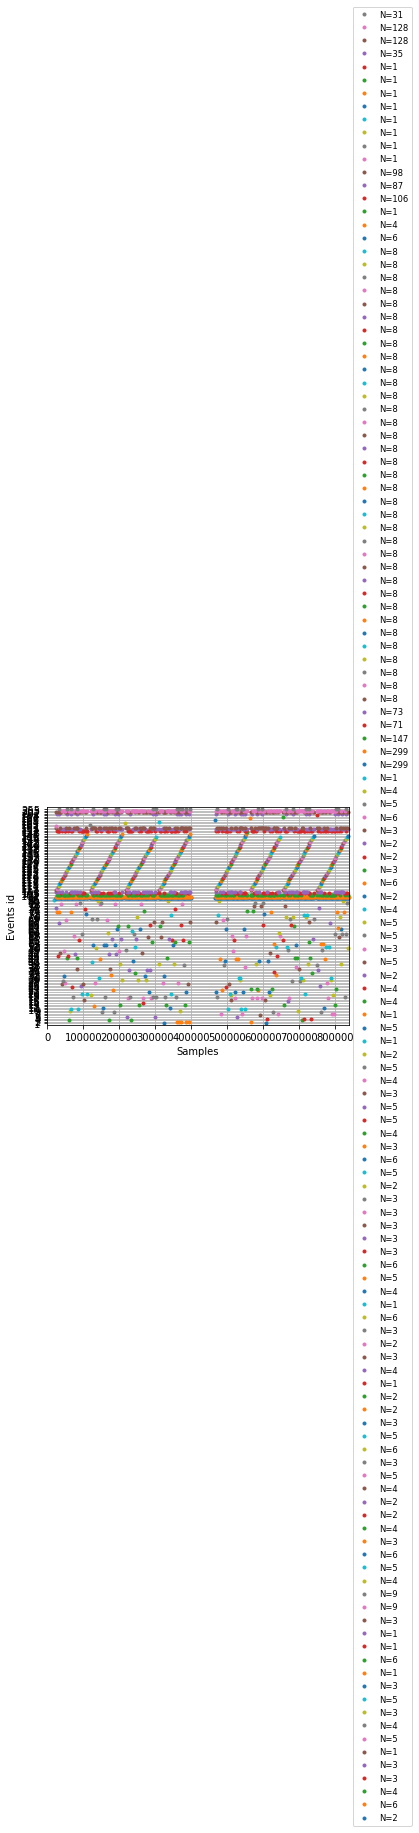

  File: SB127_MEEG_V1_DurR2
Opening raw data file /Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR2.fif...


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This filename (/Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  verbose=True)


    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 11000 ... 839999 =     11.000 ...   839.999 secs
Ready.


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  verbose=True)


2096 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  79  80  96  97 100 101 102 103 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 151 152 153 169 170
 171 172 173 174 175 176 201 202 203 255]
2082 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  79  80  96  97 101 102 103 111 112 113 114 115 116 117
 118 119 120 121 122 123

<ipython-input-17-10966a14984c>:66: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events)


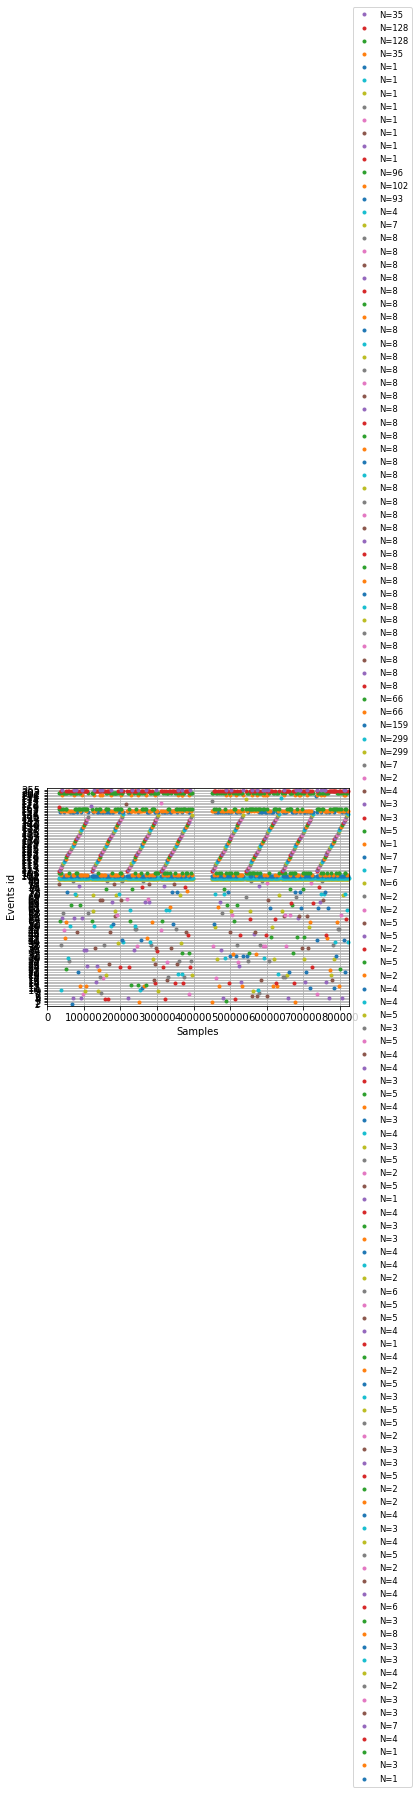

  File: SB127_MEEG_V1_DurR3
Opening raw data file /Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR3.fif...


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This filename (/Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  verbose=True)


    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 7000 ... 804999 =      7.000 ...   804.999 secs
Ready.


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  verbose=True)


2064 events found
Event IDs: [  1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  96  97 101 102 103 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 151 152 153 177 178
 179 180 181 182 183 184 192 201 202 203 255]
2051 events found
Event IDs: [  1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  96  97 101 102 103 111 112 113 114 115 116 117
 118 119 120 121 122

<ipython-input-17-10966a14984c>:66: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events)


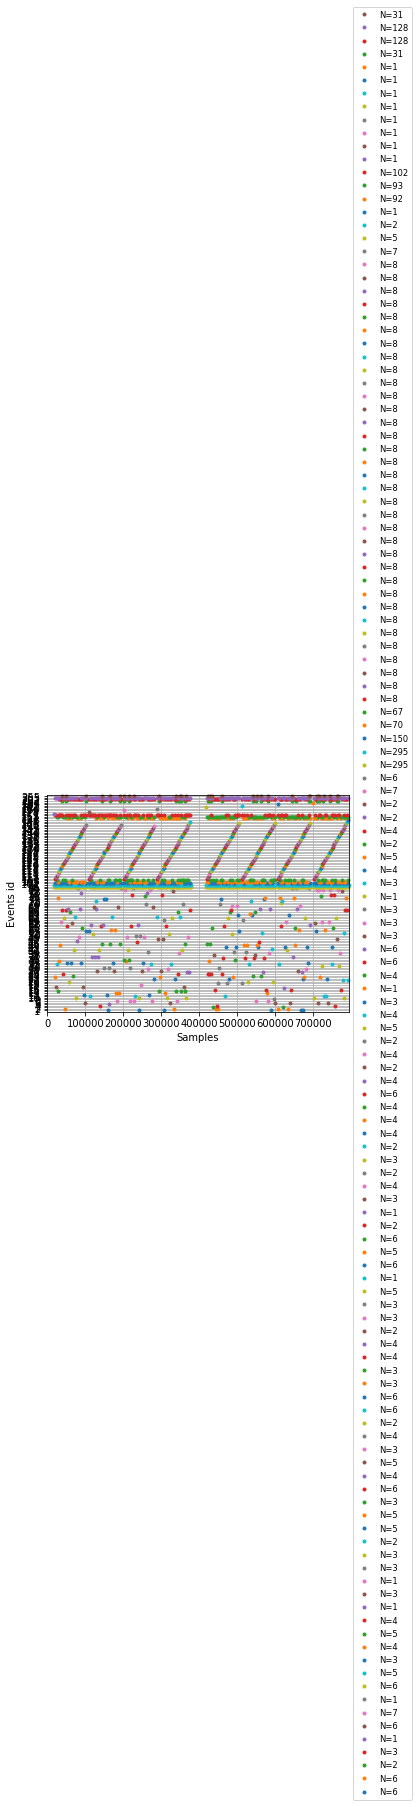

  File: SB127_MEEG_V1_DurR4
Opening raw data file /Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR4.fif...


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This filename (/Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  verbose=True)


    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 8000 ... 804999 =      8.000 ...   804.999 secs
Ready.


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  verbose=True)


2088 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  96  97 101 102 103 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 151 152 153
 185 186 187 188 189 190 191 192 200 201 202 203 255]
2067 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  96  97 101 102 103 111 112 113 114 115
 116 117 118

<ipython-input-17-10966a14984c>:66: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events)


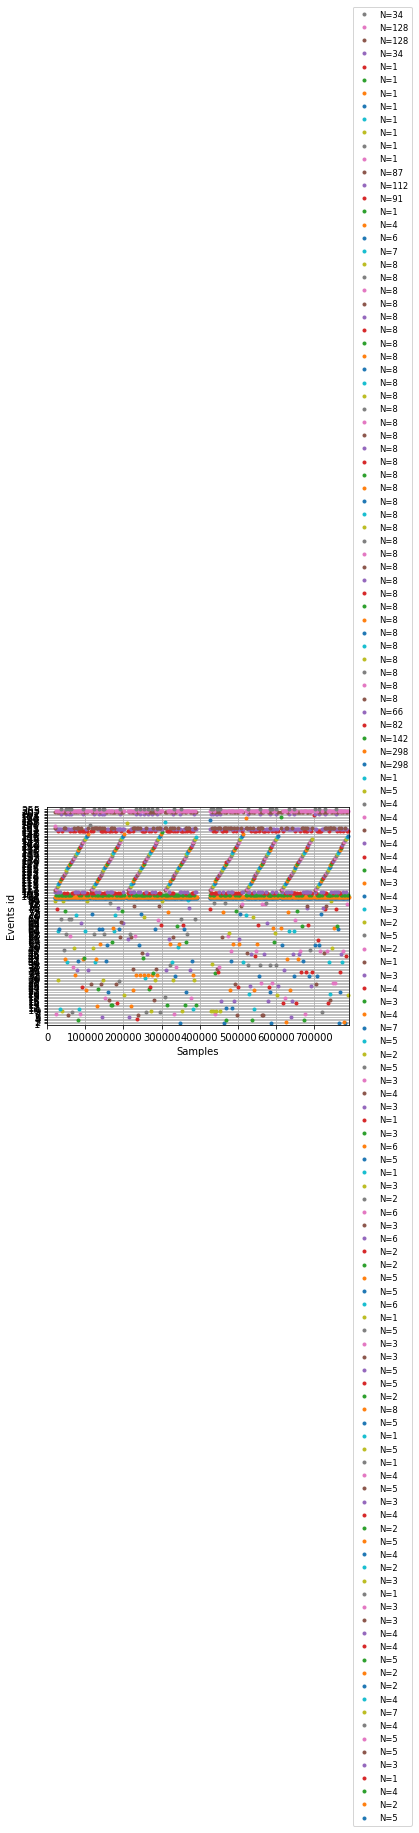

  File: SB127_MEEG_V1_DurR5
Opening raw data file /Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR5.fif...


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This filename (/Volumes/Cogitate/MEG_reorganized/SB127/V1/SB127_MEEG_V1_DurR5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  verbose=True)


    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 14000 ... 765999 =     14.000 ...   765.999 secs
Ready.


<ipython-input-17-10966a14984c>:36: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  verbose=True)


2014 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  96  97 101 102 103 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 151 152 153 192 193 194
 195 196 197 198 199 200 201 202 203 255]
2005 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  96  97 101 102 103 111 112 113 114 115 116 117
 118 119 120 121 122 123

<ipython-input-17-10966a14984c>:66: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events)


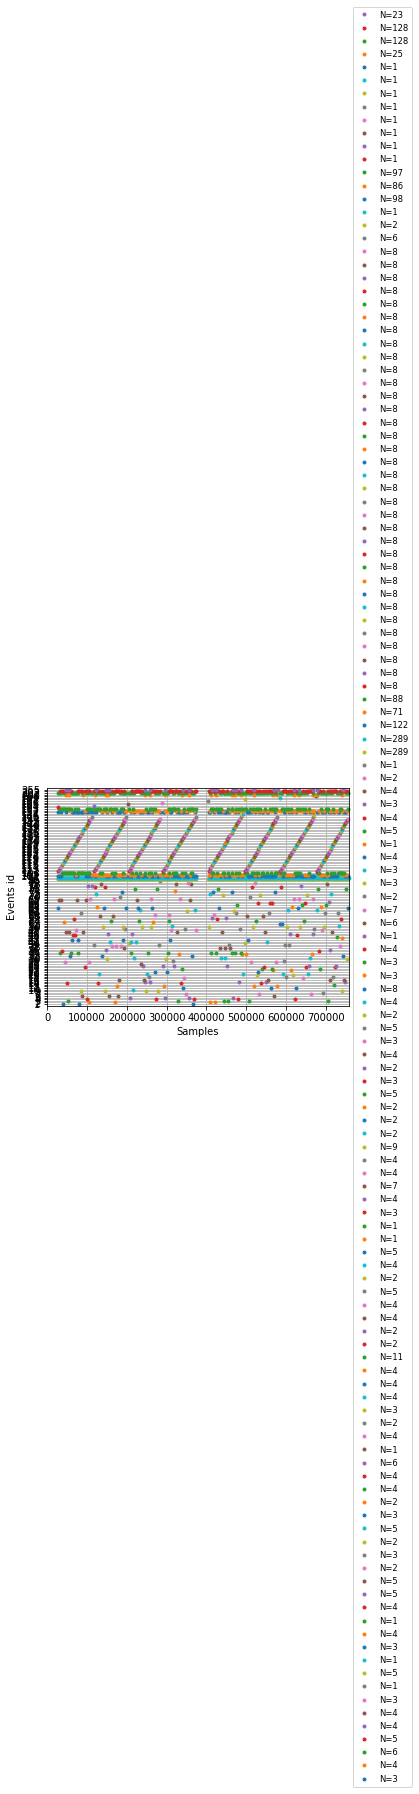

In [34]:
# %load config.py
"""
===========
Config file
===========

Configurate the parameters of the study.
"""
for subject_id in subject_list[:1]:

    # =============================================================================
    # SESSION-SPECIFIC SETTINGS
    # =============================================================================

    # Set filename based on experiment number
    if experiment_id == 1:
        file_exts = ['%s_MEEG_V1_DurR1',
                     '%s_MEEG_V1_DurR2',
                     '%s_MEEG_V1_DurR3',
                     '%s_MEEG_V1_DurR4',
                     '%s_MEEG_V1_DurR5']
        file_names = [f % (site_id+subject_id) for f in file_exts]
    elif experiment_id == 2:
        file_exts = ['%s_MEEG_V2_VGR1',
                     '%s_MEEG_V2_VGR2',
                     '%s_MEEG_V2_VGR3',
                     '%s_MEEG_V2_VGR4']#,
                     # '%s_MEEG_V2_ReplayR1',
                     # '%s_MEEG_V2_ReplayR2']
        file_names = [f % (site_id+subject_id) for f in file_exts]


    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    data_path = op.join(file_path,site_id+subject_id)
    data_path = op.join(data_path,'V' + str(experiment_id))
    out_path = op.join(data_path, "out_path")
    if not op.exists(out_path):
        os.mkdir(out_path)

    # Remove participant without EEG from EEG analysis (WIP, only works for exp1 atm)
    if site_id == 'SA':
        if experiment_id == 1:
            no_eeg_sbj = ['101', '102', '103', '104']
        elif experiment_id == 2:
            no_eeg_sbj = ['104', '106']
    elif site_id == 'SB':
        if experiment_id == 1:
            no_eeg_sbj = []
        elif experiment_id == 2:
            no_eeg_sbj = []


    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='sss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None


    # =============================================================================
    # FILTERING AND DOWNSAMPLING SETTINGS
    # =============================================================================

    # Filter and resampling params
    l_freq = 1
    h_freq = 40
    sfreq = 200


    # =============================================================================
    # ICA SETTINGS
    # =============================================================================

    ica_method = 'fastica'
    n_components = 0.99
    max_iter = 800
    random_state = 1688


    # =============================================================================
    # RUN
    # =============================================================================

    run_maxwell_filter(method=method)
    if subject_id in no_eeg_sbj:
        raise ValueError("Error: no EEG collected for this participant (%s)" % (site_id+subject_id))
    else:
        find_bad_eeg()
    if subject_id in no_eeg_sbj:
        EEG = False
    else:
        EEG = True


    artifact_annotation()

    run_events(experiment_id=experiment_id)
    
    run_ica(max_iter = max_iter, 
        n_components = n_components, 
        random_state = random_state)

In [4]:
# %load 06-apply_ica.py
"""
===============
06. Apply ICA
===============

This relies on the ICAs computed in 05-run_ica.py

Open issues:
    1. Should we automitaze EOG- and ECG-related ICs detection?
    -> up to Ling and Oscar. Do auto and cross-check afterwards
    2. Add plots?
    -> no
    3. How many comps per type should we remove?
    -> 1-2 each (if any). 2-5 in total
    4. Apply on concatenated data? -> Yes
    
"""

def apply_ica(meg_ica_eog = [], meg_ica_ecg = [],
              eeg_ica_eog = [], eeg_ica_ecg = []):

    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                           os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_artif.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Show original signal
        if EEG:
            chs = ['MEG0311', 'MEG0121', 'MEG1211', 'MEG1411', 'EEG001','EEG002', 'EOG001','EOG002']
        else:
            chs = ['MEG0311', 'MEG0121', 'MEG1211', 'MEG1411', 'EOG001','EOG002']
        chan_idxs = [raw.ch_names.index(ch) for ch in chs]
        fig1 = raw.plot(order=chan_idxs,
                       duration=50,
                       start=100)        
        fname_fig1 = op.join(out_path,
                            '06_r%s_ica_raw0.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Timecourse of input data', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        
        ###################
        # ICA on MEG data #
        ###################
        
        if [meg_ica_eog + meg_ica_ecg] != []:
            
            # Restore ICA solution from fif file
            ica_meg_fname = op.join(out_path,
                                file_name[0:14] + 'ALL-ica_meg.fif')
            ica_meg = read_ica(ica_meg_fname)
            
            # Select EOG- and ECG-related components for exclusion
            ica_meg.exclude.extend(meg_ica_eog + meg_ica_ecg)
            
            # # Plot excluded ICs
            # if meg_ica_eog != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=meg_ica_eog)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_meg_eog%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
            # if meg_ica_ecg != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=meg_ica_ecg)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_meg_ecg%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
            
        ###################
        # ICA on EEG data #
        ###################
        
        if eeg_ica_eog + eeg_ica_ecg != []:
            
            # Restore ICA solution from fif file
            ica_eeg_fname = op.join(out_path,
                                file_name[0:14] + 'ALL-ica_eeg.fif')
            ica_eeg = read_ica(ica_eeg_fname)
            
            # Select EOG- and ECG-related components for exclusion
            ica_eeg.exclude.extend(eeg_ica_eog + eeg_ica_ecg)
            
            # # Plot excluded ICs
            # if eeg_ica_eog != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=eeg_ica_eog)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_eeg_eog%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
            # if eeg_ica_ecg != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=eeg_ica_ecg)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_eeg_ecg%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
        
        ###################
        
        # Remove selected components from the signal  #TODO: @Ling why "apply" is done in two different steps?
        raw_ica = raw.copy()
        ica_meg.apply(raw_ica)
        ica_eeg.apply(raw_ica)
        
        # Show cleaned signal
        fig_ica = raw_ica.plot(order=chan_idxs,
                               duration=50,
                               start=100)        
        fname_fig_ica = op.join(out_path,
                                '06_r%s_ica_rawICA.png' % run)
        fig_ica.savefig(fname_fig_ica)
        plt.close()
        
        # Add figures to report
        pdf.ln(120)
        pdf.cell(0, 10, 'Timecourse of output data', 'B', ln=1)
        pdf.image(fname_fig_ica, 0, 175, pdf.epw)
        
        # Save cleaned raw data
        fname_out = op.join(out_path,
                            file_name + '_ica.fif')
        raw_ica.save(fname_out,overwrite=True)
    
    # Save report  #TODO: add note about removed ICs
    pdf.output(op.join(out_path,
                       'apply_ica' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [5]:
# %load 07-make_epochs.py
"""
====================
07. Make epochs
====================

Open issues:
    - baseline correction -> removed
    - apply (SSP) projections?
    - separate MEG and EEG in two different FIF files?
    - Exp.2: separate VG and replay in two different files?
    - detrand required for EEG data: when do we apply it? to epochs or to events?
    - remove peak-to-peak rejection?
    
"""


def run_epochs():

    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                            os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    
    # Create empty lists
    raw_list = list()
    events_list = list()
    metadata_list = list()
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_ica.fif')
        raw_tmp = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=False, 
            verbose='error')
        
        # Read events
        events_tmp = mne.read_events(op.join(out_path,
                                             file_name + '-eve.fif'))                           
        # Read metadata
        metadata_tmp = pd.read_csv(op.join(out_path,
                                           file_name + '-meta.csv'))
        
        # Append read data to list
        raw_list.append(raw_tmp)
        events_list.append(events_tmp)
        metadata_list.append(metadata_tmp)

    # Concatenate raw instances as if they were continuous
    raw, events = mne.concatenate_raws(raw_list,
                                       events_list=events_list)
    del raw_list
    
    # Concatenate metadata tables
    metadata = pd.concat(metadata_list)
    metadata.to_csv(op.join(out_path,
                            file_name[0:14] + 'ALL-meta.csv'),
                    index=False)
    
    # Set reject criteria
    if EEG:
        reject = reject_meg_eeg
    else:
        reject = reject_meg
    
    # Select sensor types
    picks = mne.pick_types(raw.info,
                           meg = True,
                           eeg = EEG,
                           stim = True,
                           eog = EEG,
                           ecg = EEG,
                           )
    
    # Epoch raw data
    epochs = mne.Epochs(raw,
                        events, 
                        events_id,
                        tmin, tmax,
                        baseline=None,
                        proj=True,
                        picks=picks,
                        # detrend=1,
                        reject=reject,
                        reject_by_annotation=False,
                        verbose=True)
    
    # epochs.metadata = metadata
    
    del raw
    
    # Add metadata
    epochs.metadata = metadata
    
    # Drop bad epochs based on peak-to-peak magnitude
    epochs.drop_bad()
    
    # Plot percentage of rejected epochs per channel
    fig1 = epochs.plot_drop_log()
    fname_fig1 = op.join(out_path,
                        '07_rAll_epoch_drop.png')
    fig1.savefig(fname_fig1)
    plt.close()
    
    # Add figure to report
    pdf.add_page()
    pdf.set_font('helvetica', 'B', 16)
    pdf.cell(0, 10, file_name)
    pdf.ln(20)
    pdf.set_font('helvetica', 'B', 12)
    pdf.cell(0, 10, 'Percentage of rejected epochs', 'B', ln=1)
    pdf.image(fname_fig1, 0, 45, pdf.epw)

    # Plot evoked by epoch
    fig2 = epochs.plot(picks='meg',
                      title='meg',
                      n_epochs=10)
    fname_fig2 = op.join(out_path,
                        '07_rAll_epoch_evk.png')
    fig2.savefig(fname_fig2)
    plt.close(fig2)
    
    # Add figures to report
    pdf.ln(120)
    pdf.cell(0, 10, 'Epoched data', 'B', ln=1)
    pdf.image(fname_fig2, 0, 175, pdf.epw)
    
    # Count the number of epochs defined by different events
    num = {}
    for key in events_id:
        num[key] = len(epochs[key])
    df = pd.DataFrame(num,
                      index = ["Total"])
    df.to_csv(op.join(out_path,
                      file_name[0][0:13] + 'ALL_epo.csv'),  
              index=False)
    print(df)
    
    # Save epoched data
    epochs.save(op.join(out_path,
                        file_names[0][0:13] + 'ALL_epo.fif'),                           
                    overwrite=True)
    
    # Save report  #TODO: add note about removed ICs
    pdf.output(op.join(out_path,
                       'run_epochs' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [7]:
ica_choice = {'V1':{127:[[0],[],[0],[]],
                    128:[[0],[2],[0],[]],
                    129:[[0],[18],[0],[]],
                    130:[[0],[],[0],[]],
                    131:[[3],[6],[2],[]]},
              'V2':{127:[[],[],[],[]],
                    128:[[],[],[],[]],
                    129:[[],[],[],[]],
                    130:[[],[],[],[]],
                    131:[[],[],[],[]]}} 

In [ ]:
# # Manually selected ICs  #TODO: move and read these info from a separate table file
# #MEG
# meg_ica_eog = [0]
# meg_ica_ecg = [18]
# #EEG
# eeg_ica_eog = [0]
# eeg_ica_ecg = [6]

In [ ]:
# %load config.py
"""
===========
Config file
===========

Configurate the parameters of the study.
"""
experiment_id = 1
for subject_id in subject_list[1:]:

    # =============================================================================
    # SESSION-SPECIFIC SETTINGS
    # =============================================================================

    # Set filename based on experiment number
    if experiment_id == 1:
        file_exts = ['%s_MEEG_V1_DurR1',
                     '%s_MEEG_V1_DurR2',
                     '%s_MEEG_V1_DurR3',
                     '%s_MEEG_V1_DurR4',
                     '%s_MEEG_V1_DurR5']
        file_names = [f % (site_id+subject_id) for f in file_exts]
    elif experiment_id == 2:
        file_exts = ['%s_MEEG_V2_VGR1',
                     '%s_MEEG_V2_VGR2',
                     '%s_MEEG_V2_VGR3',
                     '%s_MEEG_V2_VGR4']#,
                     # '%s_MEEG_V2_ReplayR1',
                     # '%s_MEEG_V2_ReplayR2']
        file_names = [f % (site_id+subject_id) for f in file_exts]


    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    data_path = op.join(file_path,site_id+subject_id)
    data_path = op.join(data_path,'V' + str(experiment_id))
    out_path = op.join(data_path, "out_path")
    if not op.exists(out_path):
        os.mkdir(out_path)

    # Remove participant without EEG from EEG analysis (WIP, only works for exp1 atm)
    if site_id == 'SA':
        if experiment_id == 1:
            no_eeg_sbj = ['101', '102', '103', '104']
        elif experiment_id == 2:
            no_eeg_sbj = ['104', '106']
    elif site_id == 'SB':
        if experiment_id == 1:
            no_eeg_sbj = []
        elif experiment_id == 2:
            no_eeg_sbj = []


    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='sss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None


    # =============================================================================
    # FILTERING AND DOWNSAMPLING SETTINGS
    # =============================================================================

    # Filter and resampling params
    l_freq = 1
    h_freq = 40
    sfreq = 200


    # =============================================================================
    # EPOCHING SETTINGS
    # =============================================================================

    # Set timewindow
    tmin = -0.75
    tmax = 2.25

    # Epoch rejection criteria
    reject_meg_eeg = dict(grad=4000e-13,    # T / m (gradiometers)
                          mag=4e-12,        # T (magnetometers)
                          eeg=200e-6       # V (EEG channels)
                          )
    reject_meg = dict(grad=4000e-13,    # T / m (gradiometers)
                      mag=4e-12         # T (magnetometers)
                      )

    # Set epoching event ids
    if experiment_id == 1:
        events_id = {}
        types = ['face','object','letter','false']
        for j,t in enumerate(types):
            for i in range(1,21):
                events_id[t+str(i)] = i + j * 20
    elif experiment_id == 2:
        events_id = {}
        events_id['blank'] = 50
        types = ['face','object']
        for j,t in enumerate(types):
            for i in range(1,11):
                events_id[t] = i + j * 20


    # =============================================================================
    # ICA SETTINGS
    # =============================================================================

    ica_method = 'fastica'
    n_components = 0.99
    max_iter = 800
    random_state = 1688


    # =============================================================================
    #  FACTOR AND CONDITIONS OF INTEREST
    # =============================================================================

    if experiment_id == 1:
        # factor = 'Category'
        # conditions = ['face', 'object', 'letter', 'false']

        factor = 'Duration'
        conditions = ['500ms', '1000ms', '1500ms']

        # factor = 'Relevance'
        # conditions = ['Relevant target','Relevant non-target','Irrelevant']
    elif experiment_id == 2:
        factor = 'Category'
        conditions = ['face', 'object']


    # =============================================================================
    # TIME-FREQUENCY REPRESENTATION SETTINGS
    # =============================================================================

    baseline_w = [-0.5, -0.25]     #only for plotting
    freq_band = 'both' #can be 'low', 'high' or 'both'

    # =============================================================================
    # RUN
    # =============================================================================


    if subject_id in no_eeg_sbj:
        EEG = False
    else:
        EEG = True
    tmp = ica_choice['V%d'%(experiment_id)][int(subject_id)]
    meg_ica_eog,meg_ica_ecg,eeg_ica_eog,eeg_ica_ecg = tmp[0],tmp[1],tmp[2],tmp[3]
    
    apply_ica(meg_ica_eog = meg_ica_eog,
              meg_ica_ecg = meg_ica_ecg,
              eeg_ica_eog = eeg_ica_eog,
              eeg_ica_ecg = eeg_ica_ecg)

    run_epochs()

Processing subject: 128
  File: SB128_MEEG_V1_DurR1
